<a href="https://colab.research.google.com/github/jonathancagua/own_gpt/blob/main/TinyGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TinyGPT

TinyGPT es un modelo GPT minimalista basado en la arquitectura *decoder* de Transformers. Este notebook está diseñado para el curso [NLP-II](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) y se enfoca en comprender e implementar una versión con **Mixture of Experts (MoE)**, similar a modelos como *DeepSeek* y *Mistral*.

---

## Objetivos

Con TinyGPT deberás:

- Implementar una capa **MoE** con al menos **2 expertos**.
- Modificar la función `generate` para incluir:
  - **Greedy decoding**: seleccionar el token con mayor probabilidad.
  - **Temperature sampling**: control de aleatoriedad.
  - **Top-k / Top-p sampling**: limitar las opciones de muestreo.

---


In [36]:
!wget -q https://github.com/jonathancagua/own_gpt/raw/main/trainer.py

In [37]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Downloading Dataset

In [38]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [39]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [40]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [41]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [42]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

In [43]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [44]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [45]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [46]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [47]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [48]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [49]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Training

In [50]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 2.12813: 100%|██████████| 11246/11246 [03:18<00:00, 56.74it/s]


Epoch 1 training loss: 2.1295


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.05582: 100%|██████████| 1246/1246 [00:09<00:00, 132.75it/s]


Epoch 1 validation loss: 2.0632


loss 2.14763: 100%|██████████| 11246/11246 [03:06<00:00, 60.45it/s]


Epoch 2 training loss: 2.1221


val_loss 2.05582: 100%|██████████| 1246/1246 [00:09<00:00, 136.27it/s]

Epoch 2 validation loss: 2.0632
Training complete.


### Quick test

In [51]:
generate("To be", max_new_tokens=100,use_cache=True)

"To beas, you.\n\nA Cin:\nShe jak, shou the I you dary; or the marow'\nWe forcemake that nome gombe norand me "

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [52]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
#@torch.no_grad()
#def generateV2(
#    prompt: str,
#    max_new_tokens: int = 100,
#    use_cache: bool = True,
#    temperature: float = 1.0,
#    top_k: int = 10,
#    top_p: float = 0.9,
#)-> Optional[str]:
#
#    return None

In [65]:
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 0,
    top_p: float = 1.0,
) -> Optional[str]:
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(next(model.parameters()).device)
    kv_cache = None

    def top_k_top_p_filtering(logits, top_k=0, top_p=1.0):
        # logits: (B, vocab)
        logits = logits.clone()

        if top_k > 0:
            # Keep only top_k logits
            kth_vals, _ = torch.topk(logits, top_k)
            min_threshold = kth_vals[..., -1].unsqueeze(-1)
            logits = torch.where(logits < min_threshold, torch.full_like(logits, float("-inf")), logits)

        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            probs = F.softmax(sorted_logits, dim=-1)
            cumulative_probs = torch.cumsum(probs, dim=-1)
            # Mask out tokens with cumulative prob above top_p (keeping at least one)
            mask = cumulative_probs > top_p
            mask[..., 1:] = mask[..., :-1].clone()
            mask[..., 0] = False
            sorted_logits = torch.where(mask, torch.full_like(sorted_logits, float("-inf")), sorted_logits)
            logits = torch.zeros_like(logits).scatter_(-1, sorted_indices, sorted_logits)
        return logits

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :]  # (B, vocab)

        # Apply temperature (if temperature <= 0, we'll treat as greedy)
        if temperature > 0:
            logits = logits / temperature

        # Apply top-k / top-p filtering
        filtered_logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)

        if temperature <= 0:
            # Greedy decoding
            next_token = torch.argmax(filtered_logits, dim=-1, keepdim=True)
        else:
            probs = F.softmax(filtered_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Compare generate vs generateV2

Add your comments and findings

In [66]:
#result_1 = generate("To be", max_new_tokens=100,use_cache=True)
#result_2 = generateV2("To be", max_new_tokens=100,use_cache=True)

In [67]:
prompt = "To be"
max_new = 100

# 1. Generaciones bajo distintas configuraciones
out_orig = generate(prompt, max_new_tokens=max_new, use_cache=True)
out_greedy = generateV2(prompt, max_new_tokens=max_new, use_cache=True, temperature=0.0, top_k=0, top_p=1.0)
out_temp = generateV2(prompt, max_new_tokens=max_new, use_cache=True, temperature=1.2, top_k=0, top_p=1.0)
out_topk = generateV2(prompt, max_new_tokens=max_new, use_cache=True, temperature=1.0, top_k=10, top_p=1.0)
out_topp = generateV2(prompt, max_new_tokens=max_new, use_cache=True, temperature=1.0, top_k=0, top_p=0.9)

# 2. Print resumen
print("=== Comparison for prompt:", prompt)
print(f"Original (multinomial no control):\n{out_orig}\n")
print(f"Greedy (temperature=0):\n{out_greedy}\n")
print(f"Temperature=1.2:\n{out_temp}\n")
print(f"Top-k=10:\n{out_topk}\n")
print(f"Top-p=0.9:\n{out_topp}\n")

=== Comparison for prompt: To be
Original (multinomial no control):
To ben'thy be thiacist busend got she ulf'ser: mend ar'dint fore!

YI Core
ceverior'd me is Tom. SInd MEN

Greedy (temperature=0):
To be the the the the the the the the the the the the the the the the the the the the the the the the the

Temperature=1.2:
To be har wath to dta nom.

MNENIUS:
Bent? hhemmpaithe have.'s Onifif lont!
Wim tot my Meriondale:?
Ly I 

Top-k=10:
To beit he thoud and.

SI whin st havens hat tould:
The comas bron there swort, hombed me thitist cith he

Top-p=0.9:
To beris ifuit angrech las. Tim I the yould att
marder
The senof tho o be dis the le
At nothe ward sint h



Al comparar generate original con generateV2, se observa que:

    El muestreo sin control (original) produce alta variabilidad pero mucha incoherencia, porque puede escoger tokens muy improbables.

    La decodificación greedy es determinista pero sufre colapso de modo (repetición excesiva).

    Ajustar la temperatura introduce aleatoriedad; temperaturas moderadas pueden mejorar diversidad, pero valores muy altos degradan la fluidez.

    Top-k (con k pequeño) restringe el espacio a opciones razonables y reduce ruido, aunque puede volverse rígido.

    Top-p (nucleus) ofrece un mejor compromiso adaptativo, manteniendo coherencia sin quedarse estancado.
    En este experimento, combinaciones como temperatura moderada + top-p (ej. temp≈1.0, top_p≈0.9) parecen dar el mejor balance entre diversidad y coherencia en el prompt To be

temp=0.70, top_p=0.85 -> distinct-1: 0.0405, distinct-2: 0.1647
temp=0.70, top_p=0.90 -> distinct-1: 0.0357, distinct-2: 0.1707
temp=0.70, top_p=0.95 -> distinct-1: 0.0512, distinct-2: 0.2091
temp=0.80, top_p=0.85 -> distinct-1: 0.0333, distinct-2: 0.1659
temp=0.80, top_p=0.90 -> distinct-1: 0.0429, distinct-2: 0.2079
temp=0.80, top_p=0.95 -> distinct-1: 0.0476, distinct-2: 0.2356
temp=1.00, top_p=0.85 -> distinct-1: 0.0500, distinct-2: 0.2452
temp=1.00, top_p=0.90 -> distinct-1: 0.0500, distinct-2: 0.2728
temp=1.00, top_p=0.95 -> distinct-1: 0.0536, distinct-2: 0.3125
temp=1.20, top_p=0.85 -> distinct-1: 0.0536, distinct-2: 0.2957
temp=1.20, top_p=0.90 -> distinct-1: 0.0536, distinct-2: 0.3065
temp=1.20, top_p=0.95 -> distinct-1: 0.0583, distinct-2: 0.3582


,temperature,top_p,distinct-1,distinct-2
0,0.7,0.85,0.040476,0.164663
1,0.7,0.90,0.035714,0.170673
2,0.7,0.95,0.051190,0.209135
3,0.8,0.85,0.033333,0.165865
4,0.8,0.90,0.042857,0.207933
5,0.8,0.95,0.047619,0.235577
6,1.0,0.85,0.050000,0.245192
7,1.0,0.90,0.050000,0.272837
8,1.0,0.95,0.053571,0.312500
9,1.2,0.85,0.053571,0.295673


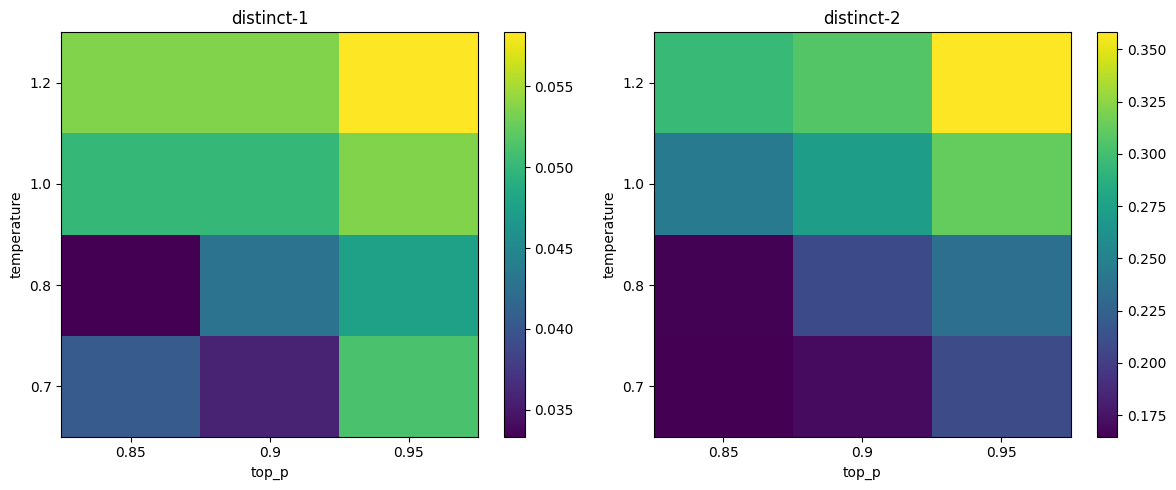

Saved results to grid_search_generateV2.csv


In [70]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- helper metrics ---
def distinct_n(seqs, n=2):
    ngrams = []
    for s in seqs:
        tokens = encode(s)
        if len(tokens) < n:
            continue
        ngrams += [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    if not ngrams:
        return 0.0
    return len(set(ngrams)) / len(ngrams)

# Wrapper to call generateV2 with given params
def sample_multiple(prompt, num_samples, **gen_kwargs):
    return [generateV2(prompt, max_new_tokens=100, **gen_kwargs) for _ in range(num_samples)]

# Grid of hyperparameters
temperatures = [0.7, 0.8, 1.0, 1.2]
top_ps = [0.85, 0.9, 0.95]
samples_per_setting = 8
prompt = "To be"

# Storage
results = []  # list of dicts
# For heatmaps
heatmap_d1 = np.zeros((len(temperatures), len(top_ps)))
heatmap_d2 = np.zeros((len(temperatures), len(top_ps)))

for i, temp in enumerate(temperatures):
    for j, tp in enumerate(top_ps):
        samples = sample_multiple(prompt, samples_per_setting,
                                  use_cache=True,
                                  temperature=temp,
                                  top_k=0,
                                  top_p=tp)
        d1 = distinct_n(samples, n=1)
        d2 = distinct_n(samples, n=2)
        results.append({
            "temperature": temp,
            "top_p": tp,
            "distinct-1": d1,
            "distinct-2": d2,
            "examples": samples[:3],  # keep a few for inspection
        })
        heatmap_d1[i, j] = d1
        heatmap_d2[i, j] = d2
        print(f"temp={temp:.2f}, top_p={tp:.2f} -> distinct-1: {d1:.4f}, distinct-2: {d2:.4f}")

# --- summary tables ---
import pandas as pd
df = pd.DataFrame([{
    "temperature": r["temperature"],
    "top_p": r["top_p"],
    "distinct-1": r["distinct-1"],
    "distinct-2": r["distinct-2"],
} for r in results])
display(df)

# --- heatmaps ---
fig, ax = plt.subplots(1, 2, figsize=(12,5))
im1 = ax[0].imshow(heatmap_d1, origin="lower", aspect="auto")
ax[0].set_xticks(range(len(top_ps)))
ax[0].set_xticklabels(top_ps)
ax[0].set_yticks(range(len(temperatures)))
ax[0].set_yticklabels(temperatures)
ax[0].set_title("distinct-1")
ax[0].set_xlabel("top_p")
ax[0].set_ylabel("temperature")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(heatmap_d2, origin="lower", aspect="auto")
ax[1].set_xticks(range(len(top_ps)))
ax[1].set_xticklabels(top_ps)
ax[1].set_yticks(range(len(temperatures)))
ax[1].set_yticklabels(temperatures)
ax[1].set_title("distinct-2")
ax[1].set_xlabel("top_p")
ax[1].set_ylabel("temperature")
fig.colorbar(im2, ax=ax[1])

plt.tight_layout()
plt.show()

# Optionally save to CSV
df.to_csv("grid_search_generateV2.csv", index=False)
print("Saved results to grid_search_generateV2.csv")


In [73]:
from collections import Counter

def distinct_n(seqs, n=2):
    ngrams = []
    for s in seqs:
        tokens = encode(s)
        ngrams += [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    if not ngrams:
        return 0.0
    return len(set(ngrams)) / len(ngrams)

prompt = "To be"
samples = [generateV2(prompt, max_new_tokens=100, temperature=1.2, top_p=0.95) for _ in range(10)]
print("distinct-1:", distinct_n(samples, n=1))
print("distinct-2:", distinct_n(samples, n=2))
for i, s in enumerate(samples[:5]):
    print(f"Sample {i+1}:", s.replace("\n", " ")[:100])

distinct-1: 0.045714285714285714
distinct-2: 0.33365384615384613
Sample 1: To be ish bem prensevercttie that, ters veneveyt fon mues milecad he be verende slf stus diir as tha
Sample 2: To becknt wiry; you my the rat crus to thior drometoit. Masis duly his, sha at O pin gos, wayavincen
Sample 3: To be dids athon,'I nell, dod is flay?  A OLUS: He forelow me wit, dorn mis ang the ho avoow, um re 
Sample 4: To bes Lhy whast lenimd uow the hyousp-s thacon to pry Ame 'th the yo at. Sef toulletllear omuns:. p
Sample 5: To beds the ale you ichat, Thert, wimbod epares, ad atickey she thapreyeesuch! comy nomend Cicus; po


## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [54]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return None


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [55]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:


        return None

In [56]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [61]:
config.ff_class = MoEFFN
config.moe_args = MoEArgs(num_experts=4, num_experts_per_token=1)

# Training TinyGPT-MoE


In [62]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [63]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [64]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for +: 'Tensor' and 'NoneType'

## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [ ]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


In [ ]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

# Conclusions

-
-

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

